In [93]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
from mne.preprocessing import ICA

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

data_path = os.path.dirname(os.path.dirname(os.getcwd()))

subject_name = ['Alice','Andrea']

# Read the epoches

In [62]:
Tmin = 0
Tmax = 3.51
trial_len = 2
save_path = data_path + '/analysis/python/data/'+s+'-coh-epo-'+str(Tmin)+'-'+str(Tmax)+'-trialLen-'+str(trial_len)+'.fif'
EE = mne.read_epochs(save_path)

epochs = EE.copy()


This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment/analysis/python/data/Andrea-coh-epo-0-3.51-trialLen-2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif or -epo.fif.gz
Reading C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment/analysis/python/data/Andrea-coh-epo-0-3.51-trialLen-2.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    3507.50 ms
        0 CTF compensation matrices available
121 matching events found
No baseline correction applied
121 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [63]:
epochs.drop_channels(extra_channels)
# for ferrara brainamp acticap
montage = mne.channels.read_montage('easycap-M1')
ch_names = montage.ch_names
remove_ch = ["Fpz", "Iz","F9", "F10", "P9", "P10", "O9", "O10", "AFz","FT9","FT10","TP9","TP10","PO9","PO10"]
a = np.nonzero(np.in1d(ch_names, remove_ch))[0]
ch_names = np.delete(ch_names,a)
montage = mne.channels.read_montage('easycap-M1',ch_names)
epochs.set_montage(montage)    

<EpochsFIF  |   121 events (all good), 0 - 3.5075 sec, baseline off, ~76.6 MB, data loaded,
 'hyper': 46
 'hypo': 25
 'normal': 50>

Setting up band-pass filter from 4 - 7 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 661 samples (1.653 sec) selected


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.6s


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


[Parallel(n_jobs=2)]: Done 7139 out of 7139 | elapsed:    3.8s finished


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


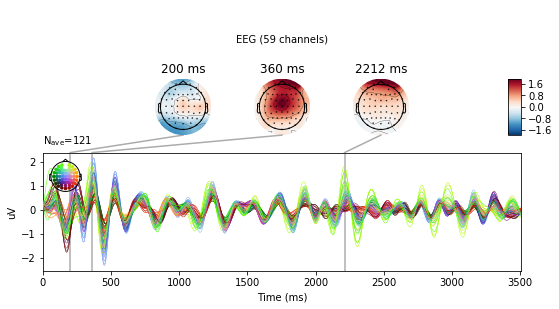

In [64]:
epochs.filter(4., 7., n_jobs=2, fir_design='firwin')
a = epochs.average().plot_joint()

In [44]:
epochs.crop(0.5,epochs.tmax)
# 1Hz high pass is often helpful for fitting ICA
epochs.filter(1., 40., n_jobs=2, fir_design='firwin')
n_components = 25  # if float, select n_components by explained variance of PCA
method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
a=ica.fit(epochs)

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1321 samples (3.303 sec) selected
filter_length (1321) is longer than the signal (1204), distortion is likely. Reduce filter length or filter a longer signal.


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.6s


Fitting ICA to data using 59 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


[Parallel(n_jobs=2)]: Done 7316 out of 7316 | elapsed:    4.5s finished


Selection by number: 25 components
Fitting ICA took 9.2s.


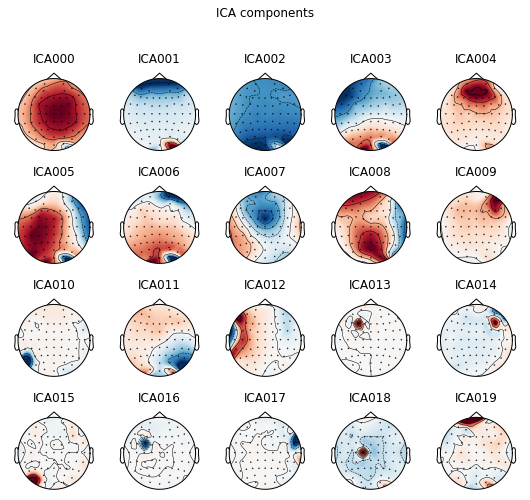

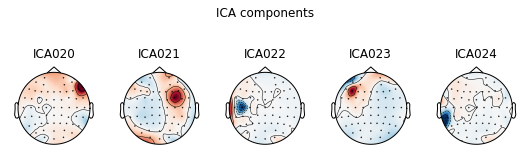

In [35]:
a=ica.plot_components()  # can you spot some potential bad guys?

In [34]:
# plot with bads
#epochs.filter(1., 40., n_jobs=2, fir_design='firwin')
#a= epochs.average().plot_joint()
ecg_inds, scores = ica.find_bads_ecg(epochs, method='ctps')


ValueError: Unable to generate artificial ECG channel

    using multitaper spectrum estimation with 7 DPSS windows


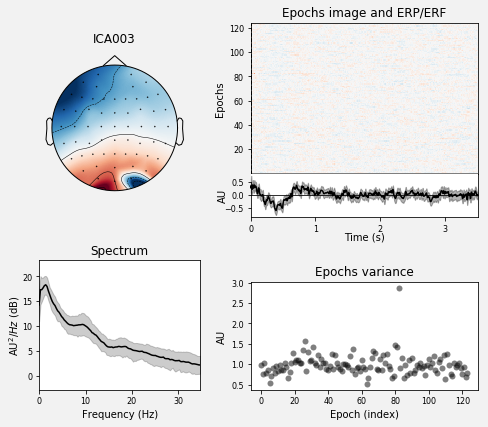

In [38]:
eog_inds =[3]
a=ica.plot_properties(epochs, picks=eog_inds,psd_args={'fmax': 35.})

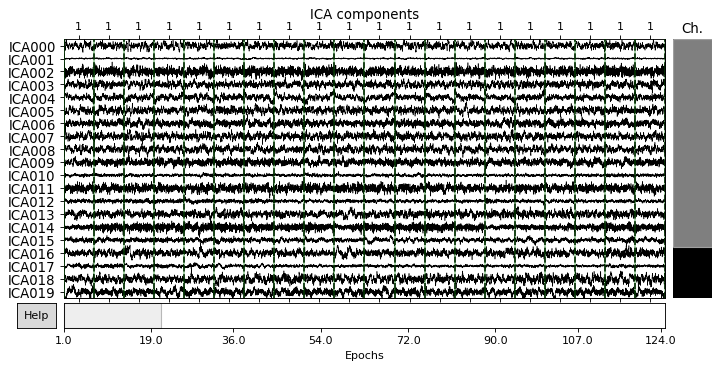

In [41]:
a=ica.plot_sources(epochs)

In [ ]:
icas = [mne.preprocessing.read_ica(fname) for fname in ica_fnames]
reference_ica = ica
reference_ica.plot_components()

icas = [reference_ica] + icas_from_other_data
template = (0, eog_inds[0])
fig_template, fig_detected = corrmap(icas, template=template, label="blinks",show=True, threshold=.8, ch_type='eeg')
eog_component = reference_ica.get_components()[:, eog_inds[0]]
